# 训练过程，尝试不同的权重衰减率  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from network import Network
from solver import train, test
from plot import plot_loss_and_acc

## 读入MNIST数据集

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def decode_image(image):
    # 归一化处理
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [784])
    image = image / 255.0
    image = image - tf.reduce_mean(image)
    return image

def decode_label(label):
    # 将标签变为one-hot编码
    return tf.one_hot(label, depth=10)

In [4]:
# 数据预处理
x_train = tf.data.Dataset.from_tensor_slices(x_train).map(decode_image)
y_train = tf.data.Dataset.from_tensor_slices(y_train).map(decode_label)
data_train = tf.data.Dataset.zip((x_train, y_train))

x_test = tf.data.Dataset.from_tensor_slices(x_test).map(decode_image)
y_test = tf.data.Dataset.from_tensor_slices(y_test).map(decode_label)
data_test = tf.data.Dataset.zip((x_test, y_test))

In [5]:
import time
from criterion import EuclideanLossLayer,SoftmaxCrossEntropyLossLayer
from optimizer import SGD
from layers import FCLayer, SigmoidLayer, ReLULayer

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
exec_result = pd.DataFrame(columns=['mode','batch_size','learning_rate_SGD', 'momentum','weight_decay','time','loss_validate','acc_validate'])

max_epoch = 20
disp_freq = 50
init_std = 0.01

In [6]:
batch_size = 100
learning_rate_SGD = 0.001

for weight_decay in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
    #Euclidean+Sigmoid
    momentum = 0.55
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]   

    #Euclidean+ReLU
    momentum = 0.99
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    reluMLP = Network()
    # 使用FCLayer和ReLULayer构建多层感知机
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]     

    #CrossEntropy+Sigmoid
    momentum = 0.55
    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]         

    #CrossEntropy+ReLU
    momentum = 0.99
    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    reluMLP = Network()
    t1=time.time()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]      

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Epoch [0][20]	 Batch [0][550]	 Training Loss 7.7248	 Accuracy 0.1100
Epoch [0][20]	 Batch [50][550]	 Training Loss 1.5896	 Accuracy 0.1167
Epoch [0][20]	 Batch [100][550]	 Training Loss 1.1096	 A

In [7]:
exec_result['acc_validate_float'] = exec_result['acc_validate'].map(lambda x: np.average(x))
exec_result

,mode,batch_size,learning_rate_SGD,momentum,weight_decay,time,loss_validate,acc_validate,acc_validate_float
0,Euclidean_Sigmoid,100,0.001,0.55,0.10000,41.829626,"[0.3995154779990792, 0.3261753784520195, 0.299...","[0.4716, 0.6672, 0.7506, 0.7864, 0.80740000000...",0.76955
1,Euclidean_ReLU,100,0.001,0.99,0.10000,41.920897,"[0.2201554069124244, 0.21051490925963956, 0.20...","[0.8182, 0.8439999999999999, 0.849199999999999...",0.84993
2,CrossEntropy_Sigmoid,100,0.001,0.55,0.10000,42.398985,"[2.0799282789475524, 1.9528335114685098, 1.885...","[0.45799999999999996, 0.6342, 0.6882, 0.714200...",0.67107
3,CrossEntropy_ReLU,100,0.001,0.99,0.10000,52.893564,"[0.7803894738426628, 0.7822880263182782, 0.777...","[0.8870000000000001, 0.8872000000000001, 0.886...",0.88379
4,Euclidean_Sigmoid,100,0.001,0.55,0.01000,84.251540,"[0.4160145915536109, 0.3324502885901587, 0.294...","[0.47100000000000003, 0.6606000000000001, 0.72...",0.80825
5,Euclidean_ReLU,100,0.001,0.99,0.01000,43.240416,"[0.11757911384385265, 0.09000380383351414, 0.0...","[0.9091999999999999, 0.9320000000000002, 0.937...",0.94301
6,CrossEntropy_Sigmoid,100,0.001,0.55,0.01000,64.363540,"[2.015180303023981, 1.7914974403402264, 1.6110...","[0.45480000000000004, 0.6365999999999999, 0.72...",0.81692
7,CrossEntropy_ReLU,100,0.001,0.99,0.01000,60.015743,"[0.27511439749298217, 0.2515398981857088, 0.24...","[0.9308000000000001, 0.9416, 0.947200000000000...",0.95340
8,Euclidean_Sigmoid,100,0.001,0.55,0.00100,65.425580,"[0.39836481136813817, 0.3307370945878176, 0.29...","[0.5067999999999999, 0.6606000000000001, 0.728...",0.80736
9,Euclidean_ReLU,100,0.001,0.99,0.00100,86.525570,"[0.13042195668680456, 0.09375013764007312, 0.0...","[0.8944, 0.9232, 0.9342, 0.9403999999999999, 0...",0.94951


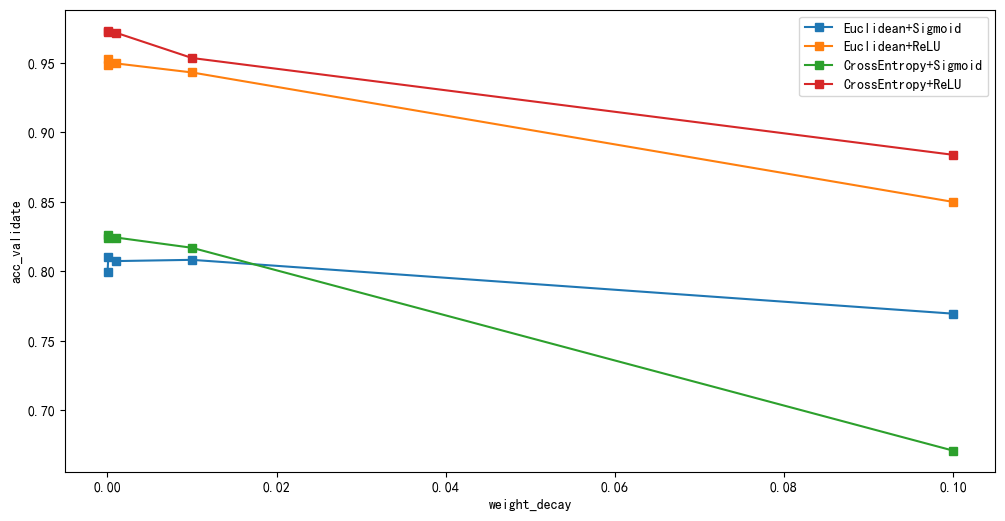

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['weight_decay'], exec_result.query("mode == 'Euclidean_Sigmoid'")['acc_validate_float'], marker='s', label = 'Euclidean+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['weight_decay'], exec_result.query("mode == 'Euclidean_ReLU'")['acc_validate_float'], marker='s', label = 'Euclidean+ReLU')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['weight_decay'], exec_result.query("mode == 'CrossEntropy_Sigmoid'")['acc_validate_float'], marker='s', label = 'CrossEntropy+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['weight_decay'], exec_result.query("mode == 'CrossEntropy_ReLU'")['acc_validate_float'], marker='s', label = 'CrossEntropy+ReLU')
plt.xlabel('weight_decay')
plt.ylabel('acc_validate')
plt.legend()

In [9]:
exec_result.to_csv('./result/result_weight_decay.csv',index=False)
# # euclidean_sigmoid.learning_rate_SGD, euclidean_relu.learning_rate_SGD, crossEntropy_sigmoid.learning_rate_SGD, crossEntropy_relu.learning_rate_SGD

# exec_result=pd.read_csv('./result_learning_rate_SGD.csv')

In [10]:
best_index = exec_result.query("mode == 'Euclidean_Sigmoid'")['acc_validate_float'].idxmax()
euclidean_sigmoid= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'Euclidean_ReLU'")['acc_validate_float'].idxmax()
euclidean_relu= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'CrossEntropy_Sigmoid'")['acc_validate_float'].idxmax()
crossEntropy_sigmoid= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'CrossEntropy_ReLU'")['acc_validate_float'].idxmax()
crossEntropy_relu= exec_result.loc[best_index]
euclidean_sigmoid.weight_decay, euclidean_relu.weight_decay, crossEntropy_sigmoid.weight_decay, crossEntropy_relu.weight_decay

(0.0001, 0.0001, 1e-05, 1e-05)

In [16]:
exec_result.query("weight_decay <= 0.00010")

,mode,batch_size,learning_rate_SGD,momentum,weight_decay,time,loss_validate,acc_validate,acc_validate_float
12,Euclidean_Sigmoid,100,0.001,0.55,0.00010,81.395794,"[0.40203178768559084, 0.33277713238912043, 0.2...","[0.48800000000000004, 0.6553999999999999, 0.73...",0.81051
13,Euclidean_ReLU,100,0.001,0.99,0.00010,88.493162,"[0.12303438996578331, 0.08860506861796655, 0.0...","[0.9087999999999999, 0.9373999999999999, 0.944...",0.95250
14,CrossEntropy_Sigmoid,100,0.001,0.55,0.00010,88.822916,"[2.0336907797261388, 1.798589231055107, 1.6011...","[0.4708, 0.6512, 0.7268000000000001, 0.7667999...",0.82375
15,CrossEntropy_ReLU,100,0.001,0.99,0.00010,89.203245,"[0.23040020357007115, 0.17043784625938993, 0.1...","[0.9358, 0.955, 0.9623999999999999, 0.9672, 0....",0.97219
16,Euclidean_Sigmoid,100,0.001,0.55,0.00001,89.748165,"[0.4055092736497922, 0.3372117355735208, 0.304...","[0.48879999999999996, 0.6388, 0.71580000000000...",0.79935
17,Euclidean_ReLU,100,0.001,0.99,0.00001,86.845003,"[0.12086158593266942, 0.09138613343652555, 0.0...","[0.9006000000000001, 0.9288000000000001, 0.937...",0.94818
18,CrossEntropy_Sigmoid,100,0.001,0.55,0.00001,98.448528,"[2.014637289436396, 1.7918110122740378, 1.6014...","[0.5055999999999998, 0.6851999999999999, 0.746...",0.82643
19,CrossEntropy_ReLU,100,0.001,0.99,0.00001,102.327386,"[0.22322786553901147, 0.16572498699567628, 0.1...","[0.938, 0.9566000000000001, 0.9628, 0.9678, 0....",0.97311
